In [ ]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torchvision import transforms

In [ ]:
!pip install git+https://github.com/smitasasindran/eva5utils.git

  Cloning https://github.com/smitasasindran/eva5utils.git to /tmp/pip-req-build-_5ggrw6q
  Running command git clone -q https://github.com/smitasasindran/eva5utils.git /tmp/pip-req-build-_5ggrw6q
     |████████████████████████████████| 634kB 4.3MB/s 
  Created wheel for eva5utils: filename=eva5utils-0.1.0-cp36-none-any.whl size=20579 sha256=3488d9e044bbb7c86decb3e61fc9e04235ddbba9aa038e1b4a911af7656f4296
  Stored in directory: /tmp/pip-ephem-wheel-cache-mgszy1_f/wheels/c6/bb/ac/e3952b213bfdb25cb23715782e1a6b4b4b5cb10e42a2b80aa9
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654021 sha256=436f81beb0cd9cb96f254015f726e30e8fedde33f7a92f5342bfd41510300b89
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built eva5utils imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
from eva5utils.dataloaders import load_cifar10
from eva5utils.model import Model7, ResNet18
from eva5utils.transforms import model9_resnet_train_transforms, model9_resnet_test_transforms, model10_resnet_train_transforms
from eva5utils.train import train_loop
from eva5utils.test import test_loop
from eva5utils.utils import plot_samples, LRFinder, TrainDataLoaderIter, ValDataLoaderIter, plot_misclassified_gradcam, plot_train_vs_test
from eva5utils.utils.helpers import show_model_summary, DEVICE, IS_CUDA, accuracy_per_class, show_gradcam, find_misclassified

In [ ]:
# Constants, put in config
epochs = 50
cuda_batch_size=128
cpu_batch_size = 4
num_workers = 4


model = ResNet18()
show_model_summary(model.to(DEVICE), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
# Load datasets
(trainloader, testloader, classes) = load_cifar10(model10_resnet_train_transforms(), model9_resnet_test_transforms(), cuda_batch_size, cpu_batch_size, num_workers)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print(DEVICE)
torch.cuda.is_available()

cuda


True

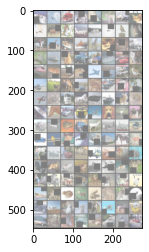

In [ ]:
plot_samples(trainloader)


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.23E-02


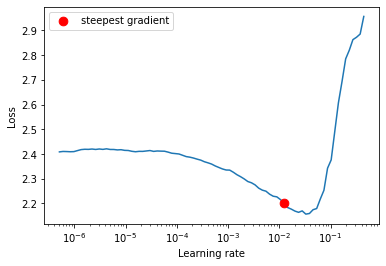

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)
lr_finder = LRFinder(model, optimizer, criterion, device=DEVICE)
lr_finder.range_test(trainloader, end_lr=1, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
min_loss = min(lr_finder.history['loss'])
min_index = lr_finder.history['loss'].index(min_loss)
lr_value = lr_finder.history['lr'][min_index]
print(lr_value)

0.03274549162877726


In [ ]:
# Training loop
optimizer = optim.SGD(model.parameters(), lr=1.45E-02 , momentum=0.9)         #3.85E-02, 2.18E-02
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=.2)
train_loss, train_acc = train_loop(epochs, trainloader, model, DEVICE, optimizer, criterion, scheduler, True)

[1,   391] loss: 367.375
[2,   391] loss: 287.560
[3,   391] loss: 238.585
[4,   391] loss: 206.736
[5,   391] loss: 180.148
[6,   391] loss: 160.472
[7,   391] loss: 141.813
[8,   391] loss: 128.351
[9,   391] loss: 116.288
[10,   391] loss: 105.174
[11,   391] loss: 94.264
[12,   391] loss: 87.760
[13,   391] loss: 79.068
[14,   391] loss: 72.300
[15,   391] loss: 68.407
[16,   391] loss: 60.188
[17,   391] loss: 56.920
[18,   391] loss: 54.525
[19,   391] loss: 49.638
[20,   391] loss: 46.388
[21,   391] loss: 45.316
[22,   391] loss: 38.496
[23,   391] loss: 40.339
[24,   391] loss: 37.598
[25,   391] loss: 35.137
[26,   391] loss: 33.511
[27,   391] loss: 20.851
[28,   391] loss: 16.811
[29,   391] loss: 15.343
[30,   391] loss: 14.780
[31,   391] loss: 13.503
[32,   391] loss: 13.061
[33,   391] loss: 13.009
[34,   391] loss: 12.372
[35,   391] loss: 12.257
[36,   391] loss: 11.757
[37,   391] loss: 12.644
[38,   391] loss: 11.424
[39,   391] loss: 11.064
[40,   391] loss: 10.669

In [ ]:
# Test Loop

test_loss, test_acc = test_loop(testloader, model, DEVICE, criterion)
accuracy_per_class(model, classes, testloader, DEVICE)

Accuracy of the network on the 10000 test images: 90 %, Test loss: 1364.3990296125412
Accuracy of plane : 84 %
Accuracy of   car : 91 %
Accuracy of  bird : 93 %
Accuracy of   cat : 76 %
Accuracy of  deer : 96 %
Accuracy of   dog : 87 %
Accuracy of  frog : 96 %
Accuracy of horse : 95 %
Accuracy of  ship : 100 %
Accuracy of truck : 97 %


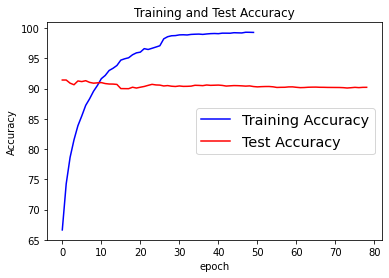

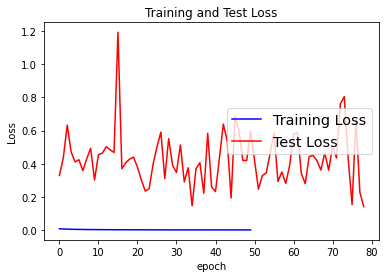

In [ ]:
plot_train_vs_test(train_acc, test_acc, 'Accuracy')
plot_train_vs_test(train_loss, test_loss, 'Loss')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


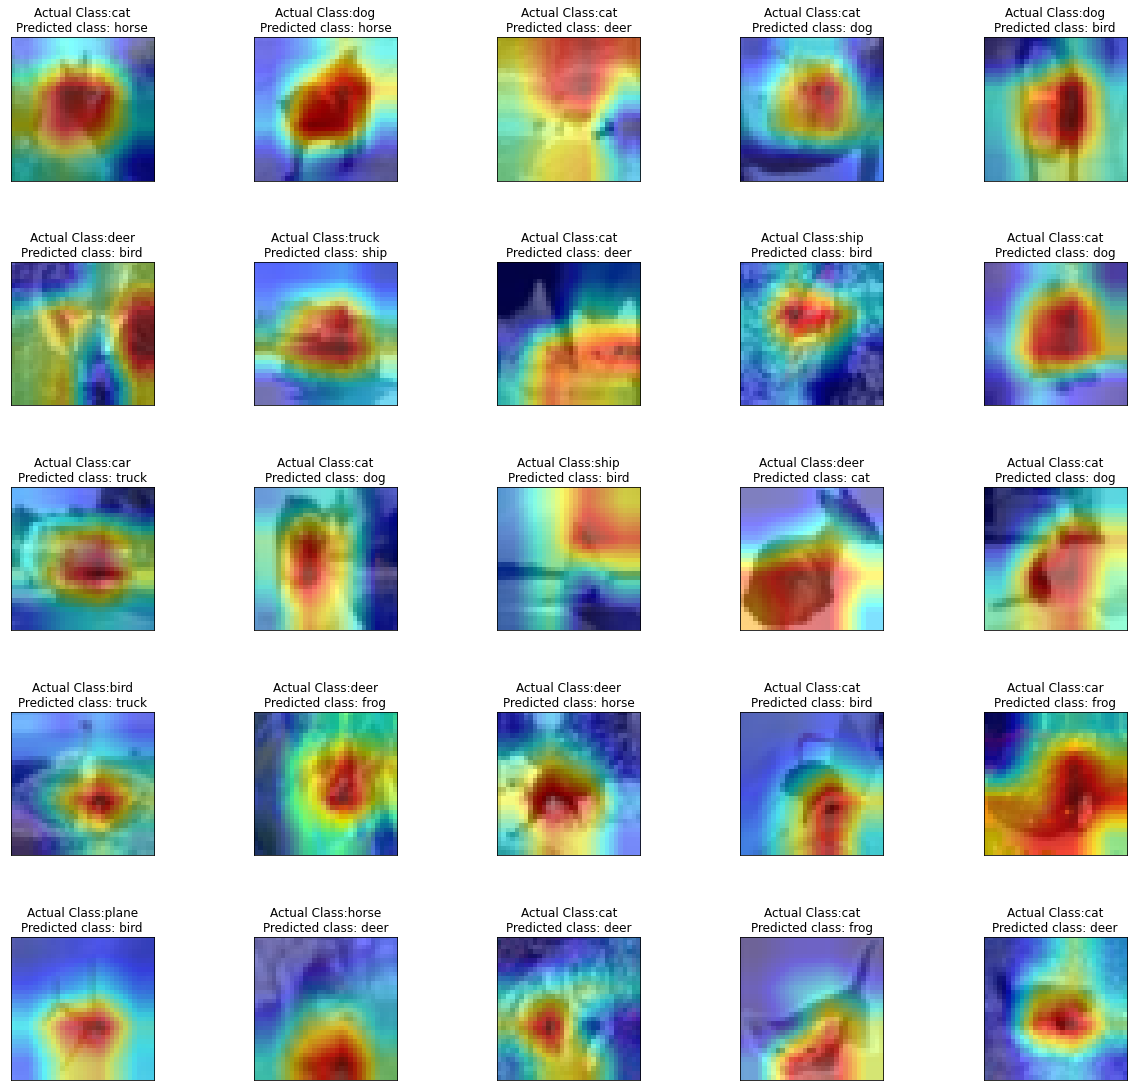

In [ ]:
# Show gradcam missclassified images
missclassified = find_misclassified(model, testloader)
plot_misclassified_gradcam(model, missclassified, classes, 'layer4', model_type='resnet')